In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import os
from collections import Counter

# Step 1: Unzip dataset (change path if needed)
zip_path = '/content/drive/MyDrive/archive.zip'
extract_path = '/content/dataset'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [ ]:
# Step 2: Set dataset_dir to the extracted folder containing classes
dataset_dir = '/content/dataset/eye reaction last'

In [ ]:
# Step 3: List class folders inside dataset_dir
print("Classes in dataset directory:")
classes = os.listdir(dataset_dir)
print(classes)

Classes in dataset directory:
['train', 'test']


In [ ]:
# Step 4: Check class distribution by counting files in each class folder
print("\nClass distribution:")
for cls in classes:
    class_path = os.path.join(dataset_dir, cls)
    if os.path.isdir(class_path):
        num_files = len(os.listdir(class_path))
        print(f"Class '{cls}': {num_files} images")

train_path = '/content/dataset/eye reaction last/train'
test_path = '/content/dataset/eye reaction last/test'

print("Train folder contents:", os.listdir(train_path))
print("Test folder contents:", os.listdir(test_path))


Class distribution:
Class 'train': 6 images
Class 'test': 6 images
Train folder contents: ['anger', 'fear', 'surprise', 'sad', 'happy', 'disgust']
Test folder contents: ['anger', 'fear', 'surprise', 'sad', 'happy', 'disgust']


In [ ]:
#  Imports for training
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input as vgg_preprocess
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# For evaluation
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score
import seaborn as sns

In [ ]:
#Data augmentation
img_height, img_width = 224, 224
batch_size = 32

train_dir = '/content/dataset/eye reaction last/train'
test_dir = '/content/dataset/eye reaction last/test'

train_datagen = ImageDataGenerator(
    preprocessing_function=vgg_preprocess,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    brightness_range=[0.7, 1.3]
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

test_datagen = ImageDataGenerator(preprocessing_function=vgg_preprocess)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 270 images belonging to 6 classes.
Found 138 images belonging to 6 classes.


BUILDING VGG16 MODEL

In [ ]:
#Build VGG16 model (transfer learning)
base_model = VGG16(weights='imagenet', include_top=False,
                   input_shape=(img_height, img_width, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# Freeze base model layers initially
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,980,422 (57.15 MB)

 Trainable params: 265,734 (1.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
#Callbacks and training (initial training)
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_vgg16_emotion_model.h5', save_best_only=True, monitor='val_loss', verbose=1)
]

history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=30,
    callbacks=callbacks
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1397 - loss: 5.2913
Epoch 1: val_loss improved from inf to 3.49563, saving model to best_vgg16_emotion_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.1394 - loss: 5.2985 - val_accuracy: 0.1739 - val_loss: 3.4956
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 611ms/step - accuracy: 0.1391 - loss: 5.0706
Epoch 2: val_loss improved from 3.49563 to 2.95891, saving model to best_vgg16_emotion_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 761ms/step - accuracy: 0.1411 - loss: 5.0195 - val_accuracy: 0.2246 - val_loss: 2.9589
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step - accuracy: 0.2422 - loss: 4.0374
Epoch 3: val_loss improved from 2.95891 to 2.55132, saving model to best_vgg16_emotion_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 625ms/step - accuracy: 0.2428 - loss: 4.0270 - val_accuracy: 0.2754 - val_loss: 2.5513
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 573ms/step - accuracy: 0.2304 - loss: 3.5762
Epoch 4: val_loss improved from 2.55132 to 2.25172, saving model to best_vgg16_emotion_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 734ms/step - accuracy: 0.2284 - loss: 3.5930 - val_accuracy: 0.3261 - val_loss: 2.2517
Epoch 5/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step - accuracy: 0.2589 - loss: 3.3538
Epoch 5: val_loss improved from 2.25172 to 2.11785, saving model to best_vgg16_emotion_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 629ms/step - accuracy: 0.2593 - loss: 3.3618 - val_accuracy: 0.3986 - val_loss: 2.1179
Epoch 6/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 637ms/step - accuracy: 0.2646 - loss: 3.2676
Epoch 6: val_loss improved from 2.11785 to 1.92348, saving model to best_vgg16_emotion_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 772ms/step - accuracy: 0.2633 - loss: 3.2697 - val_accuracy: 0.4348 - val_loss: 1.9235
Epoch 7/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step - accuracy: 0.3106 - loss: 3.0618
Epoch 7: val_loss improved from 1.92348 to 1.83943, saving model to best_vgg16_emotion_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 634ms/step - accuracy: 0.3110 - loss: 3.0535 - val_accuracy: 0.4420 - val_loss: 1.8394
Epoch 8/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 633ms/step - accuracy: 0.3140 - loss: 3.2012
Epoch 8: val_loss improved from 1.83943 to 1.73149, saving model to best_vgg16_emotion_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 773ms/step - accuracy: 0.3167 - loss: 3.1640 - val_accuracy: 0.4783 - val_loss: 1.7315
Epoch 9/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step - accuracy: 0.3005 - loss: 2.8296
Epoch 9: val_loss improved from 1.73149 to 1.70277, saving model to best_vgg16_emotion_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 629ms/step - accuracy: 0.3009 - loss: 2.8377 - val_accuracy: 0.5072 - val_loss: 1.7028
Epoch 10/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 632ms/step - accuracy: 0.3085 - loss: 2.7687
Epoch 10: val_loss improved from 1.70277 to 1.61447, saving model to best_vgg16_emotion_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 777ms/step - accuracy: 0.3136 - loss: 2.7407 - val_accuracy: 0.5362 - val_loss: 1.6145
Epoch 11/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step - accuracy: 0.3585 - loss: 2.5003
Epoch 11: val_loss improved from 1.61447 to 1.56848, saving model to best_vgg16_emotion_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 626ms/step - accuracy: 0.3589 - loss: 2.4968 - val_accuracy: 0.5507 - val_loss: 1.5685
Epoch 12/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 562ms/step - accuracy: 0.4805 - loss: 2.2848
Epoch 12: val_loss improved from 1.56848 to 1.48677, saving model to best_vgg16_emotion_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 721ms/step - accuracy: 0.4769 - loss: 2.2860 - val_accuracy: 0.5507 - val_loss: 1.4868
Epoch 13/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step - accuracy: 0.4435 - loss: 2.2069
Epoch 13: val_loss improved from 1.48677 to 1.42434, saving model to best_vgg16_emotion_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 639ms/step - accuracy: 0.4410 - loss: 2.2127 - val_accuracy: 0.5217 - val_loss: 1.4243
Epoch 14/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step - accuracy: 0.3336 - loss: 2.5782
Epoch 14: val_loss improved from 1.42434 to 1.39209, saving model to best_vgg16_emotion_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 649ms/step - accuracy: 0.3380 - loss: 2.5570 - val_accuracy: 0.5362 - val_loss: 1.3921
Epoch 15/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 554ms/step - accuracy: 0.3888 - loss: 2.3981
Epoch 15: val_loss improved from 1.39209 to 1.34134, saving model to best_vgg16_emotion_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 689ms/step - accuracy: 0.3877 - loss: 2.3776 - val_accuracy: 0.5507 - val_loss: 1.3413
Epoch 16/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step - accuracy: 0.4272 - loss: 2.1303
Epoch 16: val_loss improved from 1.34134 to 1.32284, saving model to best_vgg16_emotion_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 684ms/step - accuracy: 0.4260 - loss: 2.1333 - val_accuracy: 0.5725 - val_loss: 1.3228
Epoch 17/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step - accuracy: 0.4687 - loss: 1.8821
Epoch 17: val_loss improved from 1.32284 to 1.30120, saving model to best_vgg16_emotion_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 609ms/step - accuracy: 0.4678 - loss: 1.8907 - val_accuracy: 0.6159 - val_loss: 1.3012
Epoch 18/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 645ms/step - accuracy: 0.4336 - loss: 2.1667
Epoch 18: val_loss improved from 1.30120 to 1.29434, saving model to best_vgg16_emotion_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 780ms/step - accuracy: 0.4350 - loss: 2.1587 - val_accuracy: 0.5725 - val_loss: 1.2943
Epoch 19/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step - accuracy: 0.5008 - loss: 1.6382
Epoch 19: val_loss did not improve from 1.29434
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 644ms/step - accuracy: 0.4974 - loss: 1.6574 - val_accuracy: 0.5652 - val_loss: 1.3173
Epoch 20/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 673ms/step - accuracy: 0.4643 - loss: 1.8179
Epoch 20: val_loss improved from 1.29434 to 1.26887, saving model to best_vgg16_emotion_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 810ms/step - accuracy: 0.4608 - loss: 1.8242 - val_accuracy: 0.5652 - val_loss: 1.2689
Epoch 21/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step - accuracy: 0.4947 - loss: 1.6030
Epoch 21: val_loss improved from 1.26887 to 1.22870, saving model to best_vgg16_emotion_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 619ms/step - accuracy: 0.4919 - loss: 1.6151 - val_accuracy: 0.5580 - val_loss: 1.2287
Epoch 22/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 572ms/step - accuracy: 0.4939 - loss: 1.6758
Epoch 22: val_loss improved from 1.22870 to 1.22336, saving model to best_vgg16_emotion_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 732ms/step - accuracy: 0.4949 - loss: 1.6759 - val_accuracy: 0.5580 - val_loss: 1.2234
Epoch 23/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step - accuracy: 0.4989 - loss: 1.6342
Epoch 23: val_loss improved from 1.22336 to 1.19184, saving model to best_vgg16_emotion_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 627ms/step - accuracy: 0.4946 - loss: 1.6484 - val_accuracy: 0.5870 - val_loss: 1.1918
Epoch 24/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step - accuracy: 0.4587 - loss: 1.7694
Epoch 24: val_loss improved from 1.19184 to 1.17164, saving model to best_vgg16_emotion_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 647ms/step - accuracy: 0.4614 - loss: 1.7627 - val_accuracy: 0.5870 - val_loss: 1.1716
Epoch 25/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 530ms/step - accuracy: 0.4447 - loss: 1.7970
Epoch 25: val_loss did not improve from 1.17164
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 644ms/step - accuracy: 0.4476 - loss: 1.7866 - val_accuracy: 0.5870 - val_loss: 1.1821
Epoch 26/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step - accuracy: 0.4443 - loss: 1.7293
Epoch 26: val_loss improved from 1.17164 to 1.16920, saving model to best_vgg16_emotion_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 631ms/step - accuracy: 0.4476 - loss: 1.7172 - val_accuracy: 0.5942 - val_loss: 1.1692
Epoch 27/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 607ms/step - accuracy: 0.4906 - loss: 1.5366
Epoch 27: val_loss improved from 1.16920 to 1.14376, saving model to best_vgg16_emotion_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 740ms/step - accuracy: 0.4901 - loss: 1.5406 - val_accuracy: 0.5652 - val_loss: 1.1438
Epoch 28/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step - accuracy: 0.5575 - loss: 1.4261
Epoch 28: val_loss improved from 1.14376 to 1.13248, saving model to best_vgg16_emotion_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 622ms/step - accuracy: 0.5558 - loss: 1.4249 - val_accuracy: 0.5870 - val_loss: 1.1325
Epoch 29/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 638ms/step - accuracy: 0.5511 - loss: 1.5164
Epoch 29: val_loss improved from 1.13248 to 1.12793, saving model to best_vgg16_emotion_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 774ms/step - accuracy: 0.5452 - loss: 1.5218 - val_accuracy: 0.6014 - val_loss: 1.1279
Epoch 30/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step - accuracy: 0.4890 - loss: 1.5437
Epoch 30: val_loss improved from 1.12793 to 1.12009, saving model to best_vgg16_emotion_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 616ms/step - accuracy: 0.4908 - loss: 1.5328 - val_accuracy: 0.6014 - val_loss: 1.1201


In [ ]:
# Fine-tuning: unfreeze last 20 layers of VGG16 base and train with lower LR
# VGG16 has many layers; unfreeze last 20 layers as requested
for layer in base_model.layers[-20:]:
    layer.trainable = True

model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_finetune = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=20,
    callbacks=callbacks
)

Epoch 1/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6003 - loss: 1.1688
Epoch 1: val_loss did not improve from 1.12009
9/9 ━━━━━━━━━━━━━━━━━━━━ 80s 4s/step - accuracy: 0.5944 - loss: 1.1842 - val_accuracy: 0.5362 - val_loss: 1.1375
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 606ms/step - accuracy: 0.5770 - loss: 1.2624
Epoch 2: val_loss improved from 1.12009 to 0.96179, saving model to best_vgg16_emotion_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 768ms/step - accuracy: 0.5752 - loss: 1.2633 - val_accuracy: 0.6232 - val_loss: 0.9618
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 717ms/step - accuracy: 0.5085 - loss: 1.2680
Epoch 3: val_loss improved from 0.96179 to 0.86499, saving model to best_vgg16_emotion_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 878ms/step - accuracy: 0.5076 - loss: 1.2730 - val_accuracy: 0.6812 - val_loss: 0.8650
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 624ms/step - accuracy: 0.5687 - loss: 1.1785
Epoch 4: val_loss did not improve from 0.86499
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 748ms/step - accuracy: 0.5696 - loss: 1.1728 - val_accuracy: 0.6377 - val_loss: 0.9065
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 669ms/step - accuracy: 0.5948 - loss: 1.1459
Epoch 5: val_loss improved from 0.86499 to 0.86055, saving model to best_vgg16_emotion_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 834ms/step - accuracy: 0.5942 - loss: 1.1460 - val_accuracy: 0.6594 - val_loss: 0.8606
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 637ms/step - accuracy: 0.6063 - loss: 0.9885
Epoch 6: val_loss improved from 0.86055 to 0.85260, saving model to best_vgg16_emotion_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 824ms/step - accuracy: 0.6086 - loss: 0.9868 - val_accuracy: 0.6812 - val_loss: 0.8526
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 621ms/step - accuracy: 0.5890 - loss: 1.0224
Epoch 7: val_loss improved from 0.85260 to 0.80880, saving model to best_vgg16_emotion_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 785ms/step - accuracy: 0.5909 - loss: 1.0172 - val_accuracy: 0.6957 - val_loss: 0.8088
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 672ms/step - accuracy: 0.6485 - loss: 0.9749
Epoch 8: val_loss did not improve from 0.80880
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 794ms/step - accuracy: 0.6474 - loss: 0.9746 - val_accuracy: 0.6957 - val_loss: 0.8214
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 625ms/step - accuracy: 0.7381 - loss: 0.8162
Epoch 9: val_loss did not improve from 0.80880
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 737ms/step - accuracy: 0.7350 - loss: 0.8184 - val_accuracy: 0.6594 - val_loss: 0.8120
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 700ms/step - accuracy: 0.6854 - loss: 0.8297
Epoch 10: val_loss improved from 0.80880 to 0.75887, saving model to best_vgg16_emotion_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 861ms/step - accuracy: 0.6835 - loss: 0.8367 - val_accuracy: 0.6957 - val_loss: 0.7589
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 622ms/step - accuracy: 0.6860 - loss: 0.7741
Epoch 11: val_loss improved from 0.75887 to 0.71987, saving model to best_vgg16_emotion_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 783ms/step - accuracy: 0.6877 - loss: 0.7773 - val_accuracy: 0.7246 - val_loss: 0.7199
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 710ms/step - accuracy: 0.6941 - loss: 0.9001
Epoch 12: val_loss improved from 0.71987 to 0.71892, saving model to best_vgg16_emotion_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 880ms/step - accuracy: 0.6936 - loss: 0.8984 - val_accuracy: 0.7319 - val_loss: 0.7189
Epoch 13/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 612ms/step - accuracy: 0.7197 - loss: 0.8191
Epoch 13: val_loss improved from 0.71892 to 0.71800, saving model to best_vgg16_emotion_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 837ms/step - accuracy: 0.7170 - loss: 0.8288 - val_accuracy: 0.7246 - val_loss: 0.7180
Epoch 14/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 627ms/step - accuracy: 0.7308 - loss: 0.8168
Epoch 14: val_loss did not improve from 0.71800
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 742ms/step - accuracy: 0.7303 - loss: 0.8168 - val_accuracy: 0.6884 - val_loss: 0.7512
Epoch 15/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 724ms/step - accuracy: 0.7020 - loss: 0.8072
Epoch 15: val_loss improved from 0.71800 to 0.70934, saving model to best_vgg16_emotion_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 912ms/step - accuracy: 0.7062 - loss: 0.8010 - val_accuracy: 0.7101 - val_loss: 0.7093
Epoch 16/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 634ms/step - accuracy: 0.7830 - loss: 0.6782
Epoch 16: val_loss improved from 0.70934 to 0.69205, saving model to best_vgg16_emotion_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 796ms/step - accuracy: 0.7802 - loss: 0.6811 - val_accuracy: 0.7174 - val_loss: 0.6921
Epoch 17/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 697ms/step - accuracy: 0.7784 - loss: 0.6465
Epoch 17: val_loss did not improve from 0.69205
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 809ms/step - accuracy: 0.7780 - loss: 0.6477 - val_accuracy: 0.7174 - val_loss: 0.6929
Epoch 18/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 619ms/step - accuracy: 0.7796 - loss: 0.6237
Epoch 18: val_loss did not improve from 0.69205
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 733ms/step - accuracy: 0.7787 - loss: 0.6283 - val_accuracy: 0.7174 - val_loss: 0.6943
Epoch 19/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 715ms/step - accuracy: 0.7817 - loss: 0.6806
Epoch 19: val_loss improved from 0.69205 to 0.67314, saving model to best_vgg16_emotion_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 886ms/step - accuracy: 0.7798 - loss: 0.6842 - val_accuracy: 0.7319 - val_loss: 0.6731
Epoch 20/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 606ms/step - accuracy: 0.7493 - loss: 0.7423
Epoch 20: val_loss did not improve from 0.67314
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 717ms/step - accuracy: 0.7480 - loss: 0.7422 - val_accuracy: 0.7246 - val_loss: 0.6828


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 284ms/step
Accuracy: 0.7319
Precision: 0.7711
Recall: 0.7319
F1 Score: 0.7413
Cohen's Kappa: 0.6766

Classification Report:

              precision    recall  f1-score   support

       anger       0.91      0.74      0.82        27
     disgust       0.37      0.67      0.48        15
        fear       0.81      0.91      0.86        23
       happy       0.83      0.74      0.78        34
         sad       0.73      0.52      0.61        21
    surprise       0.78      0.78      0.78        18

    accuracy                           0.73       138
   macro avg       0.74      0.73      0.72       138
weighted avg       0.77      0.73      0.74       138



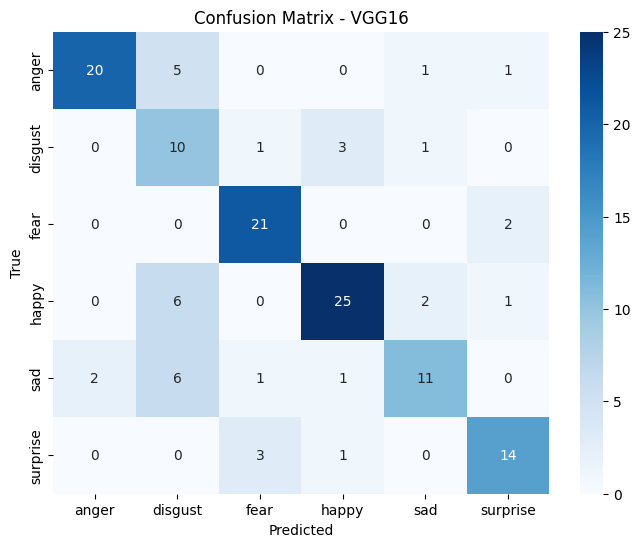

In [ ]:
#Evaluation: classification metrics and confusion matrix
test_generator.reset()
Y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

Y_pred_prob = model.predict(test_generator)
Y_pred = np.argmax(Y_pred_prob, axis=1)

accuracy = accuracy_score(Y_true, Y_pred)
precision = precision_score(Y_true, Y_pred, average='weighted', zero_division=0)
recall = recall_score(Y_true, Y_pred, average='weighted', zero_division=0)
f1 = f1_score(Y_true, Y_pred, average='weighted', zero_division=0)
kappa = cohen_kappa_score(Y_true, Y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Cohen's Kappa: {kappa:.4f}")

print("\nClassification Report:\n")
print(classification_report(Y_true, Y_pred, target_names=class_labels, zero_division=0))

# Confusion matrix plot
cm = confusion_matrix(Y_true, Y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - VGG16')
plt.show()

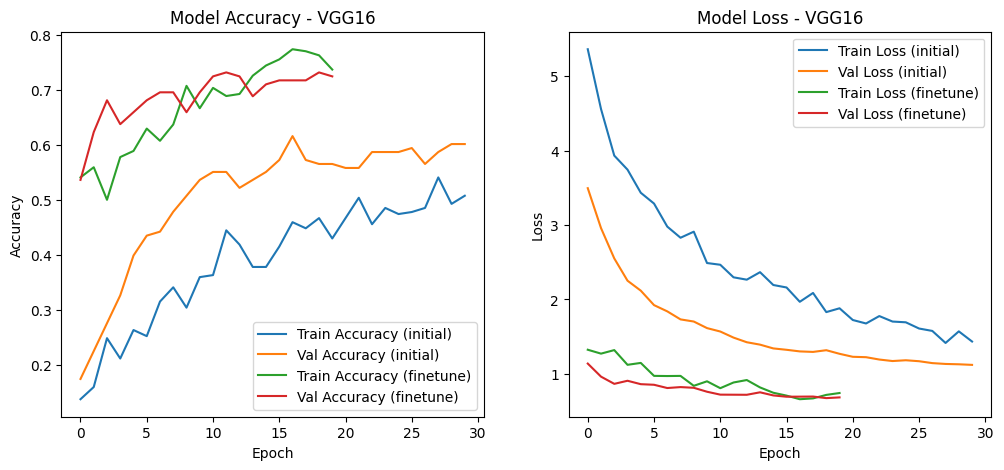

In [ ]:
#  Training/validation curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history.get('accuracy', []), label='Train Accuracy (initial)')
plt.plot(history.history.get('val_accuracy', []), label='Val Accuracy (initial)')
# If fine-tune history exists, plot it too
plt.plot(history_finetune.history.get('accuracy', []), label='Train Accuracy (finetune)')
plt.plot(history_finetune.history.get('val_accuracy', []), label='Val Accuracy (finetune)')
plt.title('Model Accuracy - VGG16')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history.get('loss', []), label='Train Loss (initial)')
plt.plot(history.history.get('val_loss', []), label='Val Loss (initial)')
plt.plot(history_finetune.history.get('loss', []), label='Train Loss (finetune)')
plt.plot(history_finetune.history.get('val_loss', []), label='Val Loss (finetune)')
plt.title('Model Loss - VGG16')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 229ms/step


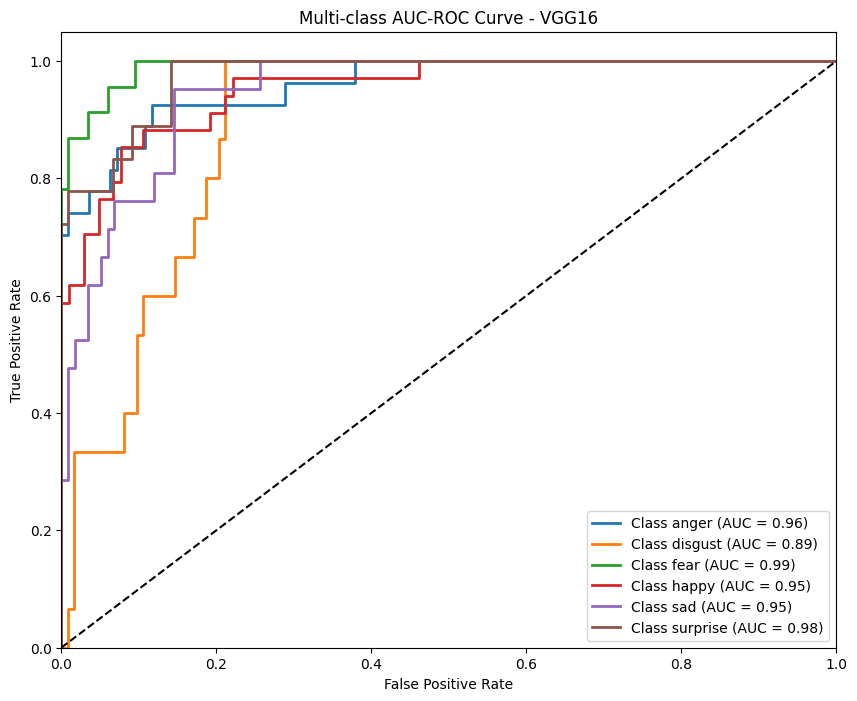

In [ ]:
# === ROC / AUC per class (same approach) ===
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

class_indices = test_generator.class_indices
class_labels = {v: k for k, v in class_indices.items()}
num_classes = len(class_labels)

y_pred = model.predict(test_generator, verbose=1)
y_true = test_generator.classes
y_true_bin = label_binarize(y_true, classes=list(range(num_classes)))

fpr, tpr, roc_auc = {}, {}, {}
for i in range(num_classes):
    try:
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    except Exception as e:
        fpr[i], tpr[i], roc_auc[i] = (None, None, None)
        print(f"Could not compute ROC for class {i}: {e}")

plt.figure(figsize=(10, 8))
for i in range(num_classes):
    if roc_auc[i] is not None:
        plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {class_labels[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class AUC-ROC Curve - VGG16')
plt.legend(loc='lower right')
plt.show()


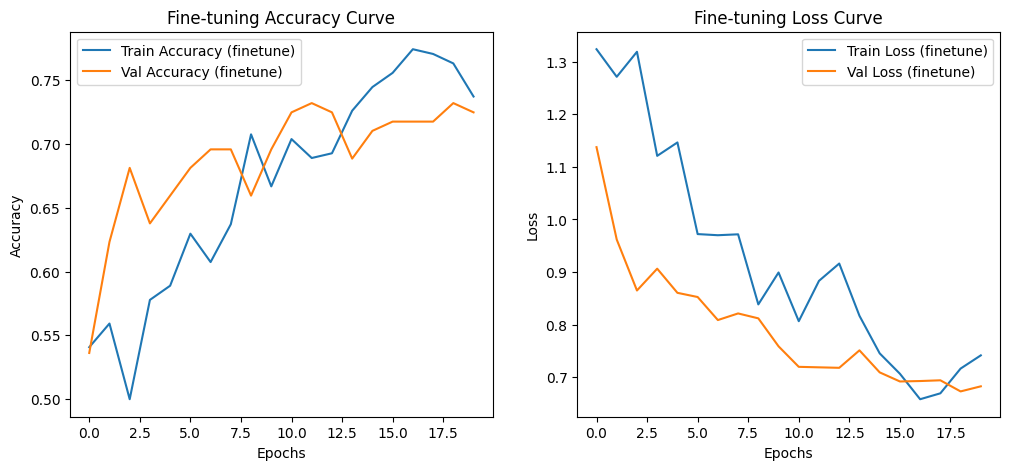

In [ ]:
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history_finetune.history.get('accuracy', []), label='Train Accuracy (finetune)')
plt.plot(history_finetune.history.get('val_accuracy', []), label='Val Accuracy (finetune)')
plt.title('Fine-tuning Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history_finetune.history.get('loss', []), label='Train Loss (finetune)')
plt.plot(history_finetune.history.get('val_loss', []), label='Val Loss (finetune)')
plt.title('Fine-tuning Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
# Upload custom images and predict
from google.colab import files
uploaded = files.upload()  # Upload images via Colab file picker
image_paths = list(uploaded.keys())
print(f"Uploaded files: {image_paths}")

Saving test anger.jpg to test anger.jpg
Saving test disgust.jpg to test disgust.jpg
Saving test fear.jpg to test fear.jpg
Saving test happy.jpg to test happy.jpg
Saving test sad.jpg to test sad.jpg
Saving test surprise.jpg to test surprise.jpg
Uploaded files: ['test anger.jpg', 'test disgust.jpg', 'test fear.jpg', 'test happy.jpg', 'test sad.jpg', 'test surprise.jpg']


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Image: test anger.jpg
Detected emotion: anger
Confidence: 1.0000


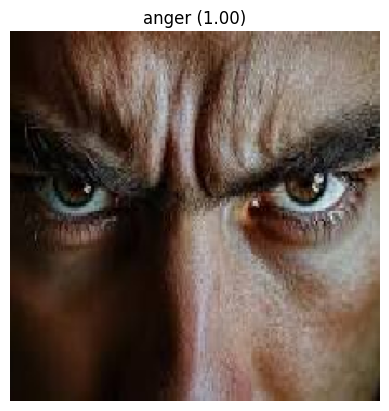

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Image: test disgust.jpg
Detected emotion: happy
Confidence: 0.9707


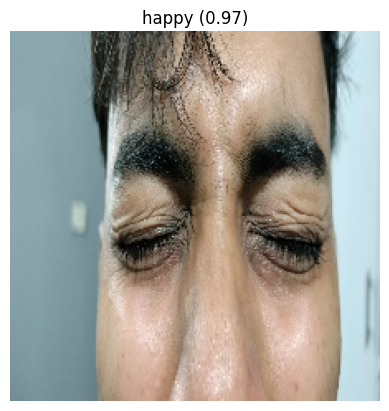

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Image: test fear.jpg
Detected emotion: fear
Confidence: 0.9911


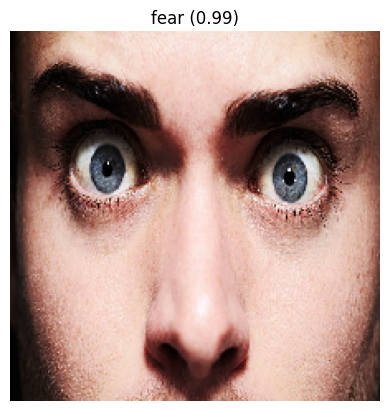

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Image: test happy.jpg
Detected emotion: happy
Confidence: 0.5228


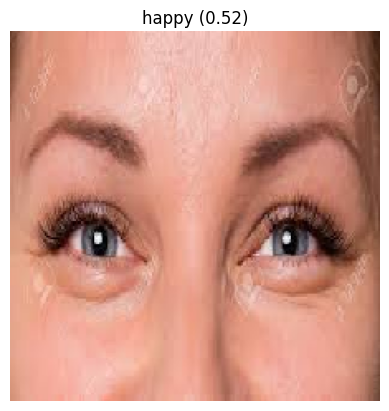

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Image: test sad.jpg
Detected emotion: anger
Confidence: 0.9977


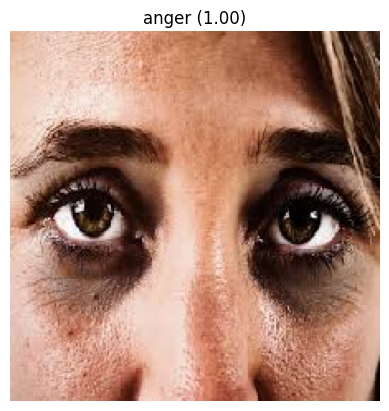

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Image: test surprise.jpg
Detected emotion: surprise
Confidence: 0.9582


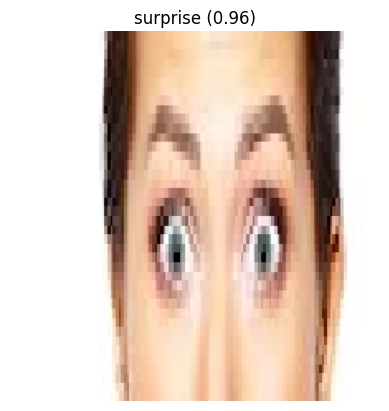

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Map indices to class labels for printing
class_indices = test_generator.class_indices
class_labels = {v: k for k, v in class_indices.items()}

for img_path in image_paths:
    img = load_img(img_path, target_size=(img_height, img_width))
    plt.imshow(img)
    plt.axis('off')
    img_array = img_to_array(img)
    img_array_expanded = np.expand_dims(img_array, axis=0)
    img_preprocessed = vgg_preprocess(img_array_expanded)

    preds = model.predict(img_preprocessed)
    class_idx = np.argmax(preds[0])
    confidence = preds[0][class_idx]

    print(f"Image: {img_path}")
    print(f"Detected emotion: {class_labels[class_idx]}")
    print(f"Confidence: {confidence:.4f}")

    plt.title(f"{class_labels[class_idx]} ({confidence:.2f})")
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


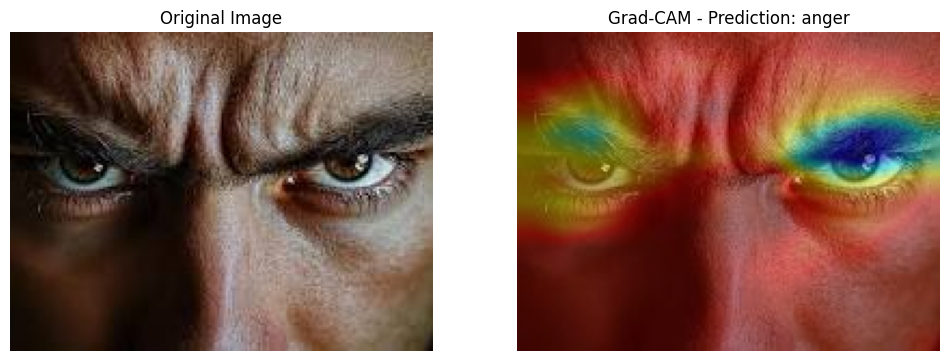

test anger.jpg → Predicted: anger (1.00)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


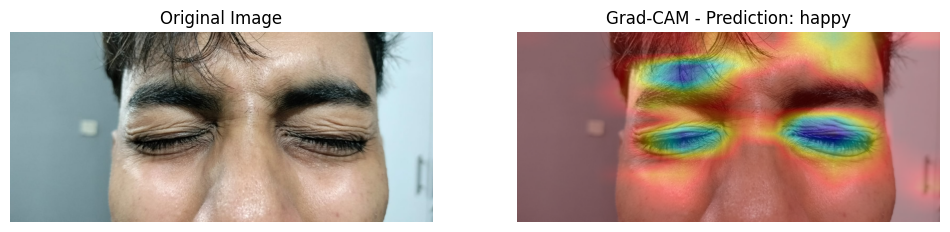

test disgust.jpg → Predicted: happy (0.97)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


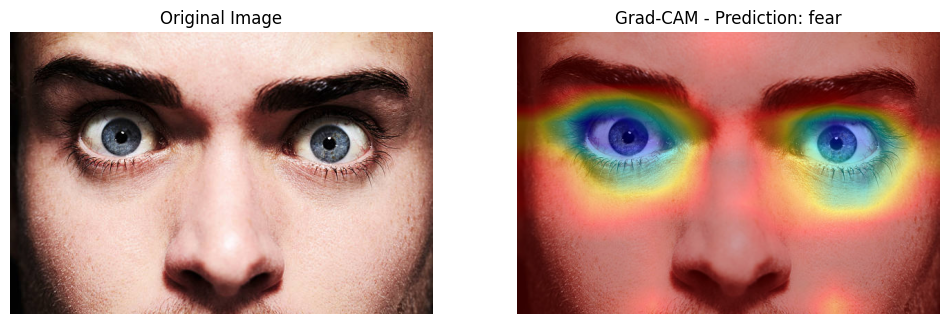

test fear.jpg → Predicted: fear (0.99)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


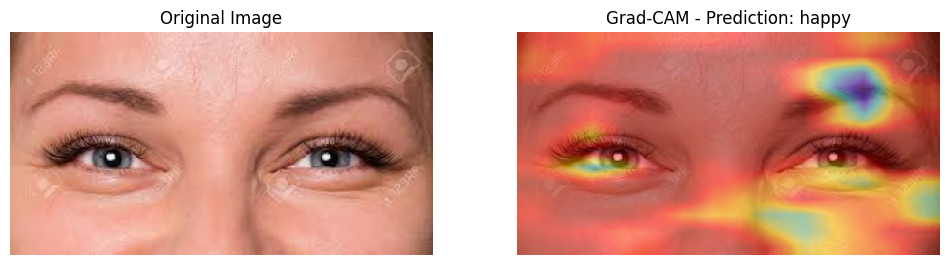

test happy.jpg → Predicted: happy (0.52)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


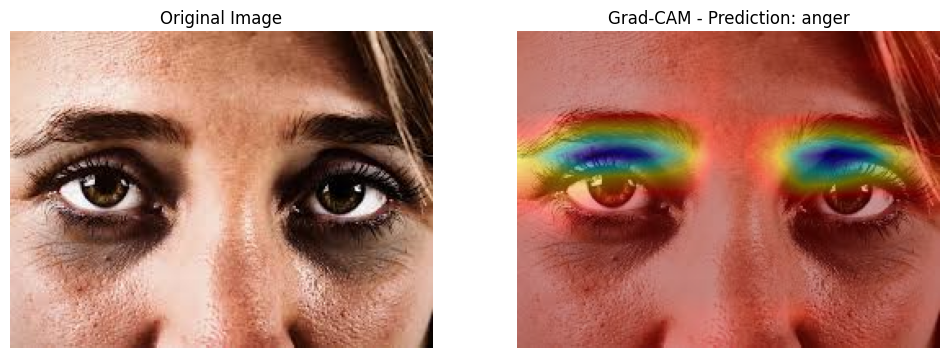

test sad.jpg → Predicted: anger (1.00)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


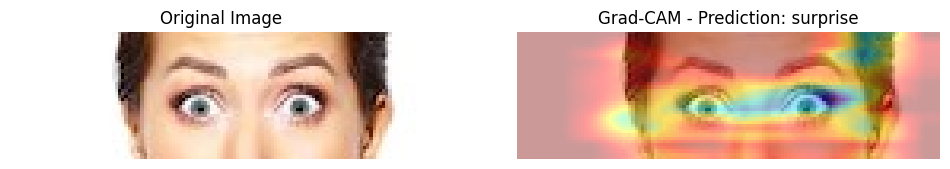

test surprise.jpg → Predicted: surprise (0.96)


In [ ]:
# === Grad-CAM for VGG16 (last conv layer: 'block5_conv3') ===
import cv2
import tensorflow as tf

def generate_gradcam_vgg(model, img_path, last_conv_layer_name='block5_conv3', preprocess_func=vgg_preprocess, img_size=(224,224)):
    img = load_img(img_path, target_size=img_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_pre = preprocess_func(img_array)

    preds = model.predict(img_pre)
    pred_index = np.argmax(preds[0])

    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_pre)
        loss = predictions[:, pred_index]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0].numpy()
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        conv_outputs[:, :, i] *= pooled_grads[i]

    heatmap = np.mean(conv_outputs, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= heatmap.max() if heatmap.max() != 0 else 1

    original_img = cv2.imread(img_path)
    original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

    heatmap_resized = cv2.resize(heatmap, (original_img.shape[1], original_img.shape[0]))
    heatmap_resized = np.uint8(255 * heatmap_resized)
    heatmap_colored = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)

    superimposed_img = cv2.addWeighted(original_img, 0.6, heatmap_colored, 0.4, 0)

    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.imshow(original_img)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.imshow(superimposed_img)
    plt.title(f"Grad-CAM - Prediction: {class_labels[pred_index]}")
    plt.axis("off")
    plt.show()

    return preds, class_labels[pred_index]

# Generate Grad-CAM for uploaded images
for img_path in image_paths:
    preds, pred_class = generate_gradcam_vgg(model, img_path, last_conv_layer_name='block5_conv3', preprocess_func=vgg_preprocess, img_size=(224,224))
    print(f"{img_path} → Predicted: {pred_class} ({np.max(preds[0]):.2f})")

In [ ]:
model.save("vgg16_finetuned_emotion_model.h5")


In [ ]:
from google.colab import files
files.download("vgg16_finetuned_emotion_model.h5")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>